In [17]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200
plt.style.use('Cole_2018.mplstyle')

# 1. Load data

### 1a. Follower IDs and following IDs

In [18]:
# Parse js file
with open('/gh/data/personal-data-requests/twitter/follower.js') as file:
    data = file.read() 
follower_ids = pd.read_json(data[28:])['follower'].apply(pd.Series)['accountId'].values
follower_ids[:10]

array(['922286882368708609', '323033429', '1117411592138907648',
       '1145341446129672205', '1154816545073139712', '967423105458196482',
       '746799054089240576', '2841553263', '823676765952413696',
       '82690534'], dtype=object)

In [19]:
# Parse js file
with open('/gh/data/personal-data-requests/twitter/following.js') as file:
    data = file.read() 
following_ids = pd.read_json(data[29:])['following'].apply(pd.Series)['accountId'].values
following_ids[:10]

array(['357606935', '1154816545073139712', '21514744', '8953122',
       '18208354', '905435496968585218', '565603465', '4105002613',
       '2995155201', '913042198391775232'], dtype=object)

In [20]:
print(len(follower_ids))
print(len(following_ids))

653
411


### 1b. Tweets

In [21]:
# Parse js file
with open('/gh/data/personal-data-requests/twitter/tweet.js') as file:
    data = file.read() 
df_tweets = pd.read_json(data[25:])
df_tweets.loc[[0]]

,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,possibly_sensitive,retweet_count,retweeted,source,truncated
0,2019-07-28 18:42:43,"[0, 101]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @Kurz_Gesagt: NEW VIDEO: Tiny Bombs in your...,1155549160134737920,1155549160134737920,NaN,NaN,NaN,NaN,NaN,en,0.0,0,False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False


In [22]:
print(len(df_tweets))
print(df_tweets['possibly_sensitive'].sum())

943
0.0


### 1c. Likes

In [23]:
# Parse js file
with open('/gh/data/personal-data-requests/twitter/like.js') as file:
    data = file.read() 
df_likes = pd.read_json(data[24:])['like'].apply(pd.Series)
df_likes.head()

,tweetId,fullText,expandedUrl
0,1157017249905090560,Mom who gently rests her hand on son’s belt in...,https://twitter.com/i/web/status/1157017249905...
1,1154084686907478016,1989: 2019: https://t...,https://twitter.com/i/web/status/1154084686907...
2,1153176206298288128,"I don’t see how this experiment helps, but the...",https://twitter.com/i/web/status/1153176206298...
3,1152978489349419014,Deaf science student creates over 100 new sign...,https://twitter.com/i/web/status/1152978489349...
4,1153073733025685504,I’ve been watching Netflix's 'Dark'. I think I...,https://twitter.com/i/web/status/1153073733025...


In [24]:
len(df_likes)

3492

# 2. Get tweets I liked from tweepy

In [25]:
if False:
    import tweepy
    import time

    # Load config
    def load_config():
        text_file = open('/gh/data/twitter/keys.txt', "r")
        lines = text_file.read().split('\n')
        consumer_key = lines[0]
        consumer_secret = lines[1]
        access_token = lines[2]
        access_secret = lines[3]
        return consumer_key, consumer_secret, access_token, access_secret

    consumer_key, consumer_secret, access_token, access_secret = load_config()

    # Set config
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    
    # Get tweets
    failed_tweets = []
    failed_tweets_other = []
    likes_info = defaultdict(list)
    for i, row in df_likes.iterrows():
        if i % 10 == 0:
            print(i)
            
        getting_tweet = True
        got_tweet = False
        while getting_tweet:
            try:
                tweet = api.get_status(row['tweetId'])
                getting_tweet = False
                got_tweet = True
                
            except Exception as e:
                if "'code': 63" in str(e):
                    print('Error getting tweet {}'.format(row['expandedUrl']))
                    failed_tweets.append(row['tweetId'])
                    getting_tweet = False
                elif "'code': 34," in str(e):
                    print('Error getting tweet {}'.format(row['expandedUrl']))
                    failed_tweets.append(row['tweetId'])
                    getting_tweet = False
                elif "Rate limit exceeded" in str(e):
                    print('Rate limit exceeded. sleep for a minute.')
                    time.sleep(60)
                else:
                    print('some other error for {}'.format(row['expandedUrl']))
                    failed_tweets_other.append(row['tweetId'])
                    getting_tweet = False
                    
            if got_tweet:
                likes_info['id'].append(row['tweetId'])
                likes_info['text'].append(tweet.text)
                likes_info['author'].append(tweet.author.screen_name)
                likes_info['dt'].append(tweet.created_at)

    df_likes_info = pd.DataFrame(likes_info)
    
    now_dt = datetime.datetime.utcnow().strftime('%Y%m%d-%H%M')
    df_likes_info.to_csv('/gh/data/personal-data-requests/twitter/df_likes_info_{}.js'.format(now_dt))
else:
    df_likes_info = pd.read_csv('/gh/data/personal-data-requests/twitter/df_likes_info_20190815-0624.js',
                                index_col=0, parse_dates=['dt'])
df_likes_info.head()

,id,text,author,dt
0,1157017249905090560,Mom who gently rests her hand on son’s belt in...,johnnyfrohman,2019-08-01 19:56:23
1,1154084686907478016,1989: 2019: https://t...,goodbeanalt,2019-07-24 17:43:25
2,1153176206298288128,"I don’t see how this experiment helps, but the...",OdedRechavi,2019-07-22 05:33:27
3,1152978489349419014,Deaf science student creates over 100 new sign...,LEMacKz,2019-07-21 16:27:47
4,1153073733025685504,I’ve been watching Netflix's 'Dark'. I think I...,Tomdonoghue,2019-07-21 22:46:15


# 3. Most liked accounts

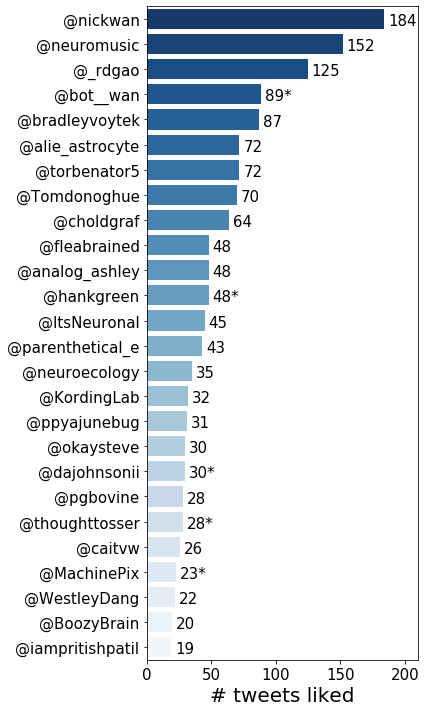

In [26]:
# Prep data to plot
n_min = 19
df_plt = df_likes_info['author'].value_counts().reset_index().rename(columns={'index': 'author', 'author': 'count'})
df_plt = df_plt[df_plt['count'] >= n_min]
df_plt['author'] = ['@' + x for x in df_plt['author']]

# Plot bars
plt.figure(figsize=(6,10))
g=sns.barplot(x='count', y='author', data=df_plt,
              palette='Blues_r')

# Plot numbers
for index, row in df_plt.iterrows():
    if row['author'] in ['@bot__wan', '@hankgreen', '@dajohnsonii', '@thoughttosser', '@MachinePix']:
        end_str = '*'
    else:
        end_str = ''
    g.text(x=row['count'] + 3,
           y=index + .25,
           s=str(row['count']) + end_str,
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# tweets liked')
plt.xlim((0,210))
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/twitter_liked_accounts_ranked.png')

# 4. Wordcloud of tweets I've liked

(-0.5, 999.5, 807.5, -0.5)

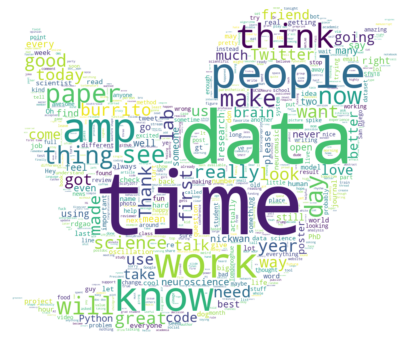

In [27]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Get text of notes
all_liked_words_str = ' '.join(df_likes['fullText'].dropna().values)

# generate word cloud without stopwords
stopwords = set(list(STOPWORDS) + ['https', 'scottrcole', 'new', 'co', 'bradleyvoytek', 'one'])
stopwords.add("said")
wc = WordCloud(background_color="white", max_words=2000, width=1000, height=1000,
               stopwords=stopwords, mask=np.array(Image.open('twitter_mask.png')))
wc.generate(all_liked_words_str)

# store to file
wc.to_file('/gh/srcole.github.io/assets/personaldata/twitter_liked_wordcloud.png')

# show
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# 5. Get word counts for liked tweets

In [28]:
liked_word_counts = pd.Series(all_liked_words_str.lower().split(' '))
word_counts = liked_word_counts.value_counts()

unusual_words = ['data', 'science', 'lab', 'burrito', 'paper', 'twitter', 'shape',
                 'thanks', 'neural', 'poster', 'code', 'years', 'research',
                 'oscillations', 'learning', 'grad', 'phd', 'analysis', 'human', 
                 'friends', 'neuroscience', 'stream', 'python', 'review', 'machine']

word_in_tweet_counts = defaultdict(int)
for i, row in df_likes.iterrows():
    for w in unusual_words:
        if (' ' + w + ' ') in row['fullText'].lower():
            word_in_tweet_counts[w] += 1

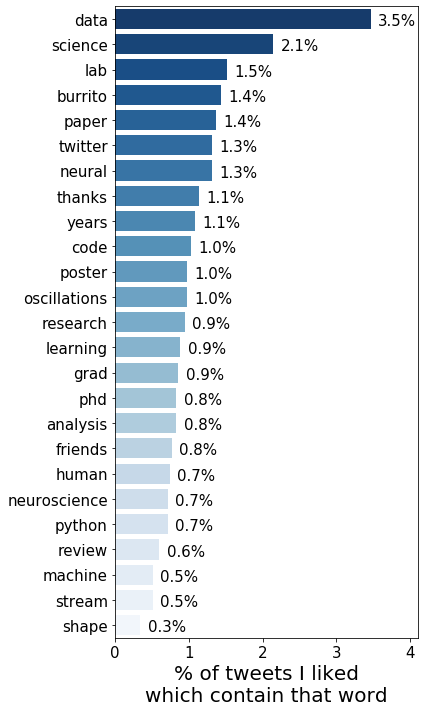

In [29]:
df_plt = pd.DataFrame(list(word_in_tweet_counts.items()), columns=['word', 'count']).sort_values('count', ascending=False).reset_index(drop=True)
df_plt['frac'] = 100 * ((df_plt['count'] / len(df_likes)))

# Plot bars
plt.figure(figsize=(6,10))
g=sns.barplot(x='frac', y='word', data=df_plt,
            palette='Blues_r',
#               palette=sns.color_palette('Greens_d', n_colors=len(df_plt))
             )

# Plot numbers
for index, row in df_plt.iterrows():
    
    g.text(x=row['frac'] + .1,
           y=index + .25,
           s='{:.1f}%'.format(row['frac']),
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('% of tweets I liked\nwhich contain that word')
plt.xlim((0,4.1))
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/twitter_liked_word_rate.png')

# 6. Word counts in my tweets

In [30]:
all_tweets_words_str = ' '.join(df_tweets['full_text'].dropna().values)
tweets_word_counts = pd.Series(all_tweets_words_str.lower().split(' '))
word_counts = tweets_word_counts.value_counts()

unusual_words2 = [';)', 'burrito', 'brain', 'paper', 'analysis', ':)', 'california', '#sandiego',
                 'python', 'future', 'guess', 'little', 'neural',  'interesting', 'science', 'spiking', 'important',
                 'open', 'shape', 'data'
                ]

word_in_tweet_counts = defaultdict(int)
for i, row in df_tweets.iterrows():
    for w in unusual_words2:
#         if (' ' + w + ' ') in row['full_text'].lower():
        if w in row['full_text'].lower():
            word_in_tweet_counts[w] += 1

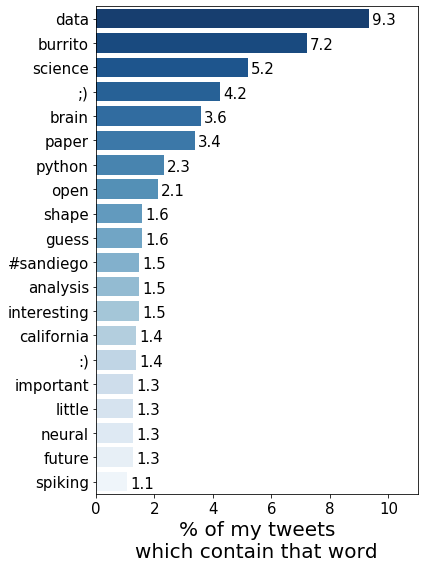

In [31]:
df_plt = pd.DataFrame(list(word_in_tweet_counts.items()), columns=['word', 'count']).sort_values('count', ascending=False).reset_index(drop=True)
df_plt['frac'] = 100 * ((df_plt['count'] / len(df_tweets)))

# Plot bars
plt.figure(figsize=(6,8))
g=sns.barplot(x='frac', y='word', data=df_plt,
            palette='Blues_r',
#               palette=sns.color_palette('Greens_d', n_colors=len(df_plt))
             )

# Plot numbers
for index, row in df_plt.iterrows():
    
    g.text(x=row['frac'] + .1,
           y=index + .25,
           s='{:.1f}'.format(row['frac']),
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('% of my tweets\nwhich contain that word')
plt.xlim((0,11))
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/twitter_posts_word_rate.png')

### wordcloud of my tweets

(-0.5, 999.5, 807.5, -0.5)

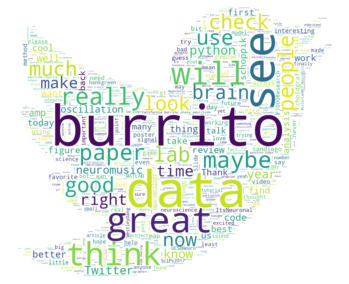

In [32]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# generate word cloud without stopwords
stopwords = set(list(STOPWORDS) + ['https', 'scottrcole', 'new', 'co', 'bradleyvoytek', 'one',
                                   'RT', '_rdgao', 'Tomdonoghue', 'nickwan', 'torbenator5', 'parenthetical_e'])
stopwords.add("said")
wc = WordCloud(background_color="white", max_words=2000, width=1000, height=1000,
               stopwords=stopwords, mask=np.array(Image.open('twitter_mask.png')))
wc.generate(all_tweets_words_str)

# store to file
wc.to_file('/gh/srcole.github.io/assets/personaldata/twitter_my_tweets_wordcloud.png')

# show
plt.figure(figsize=(6,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")